[[0.39237904 0.1        0.78475807 0.1        0.62286289]]


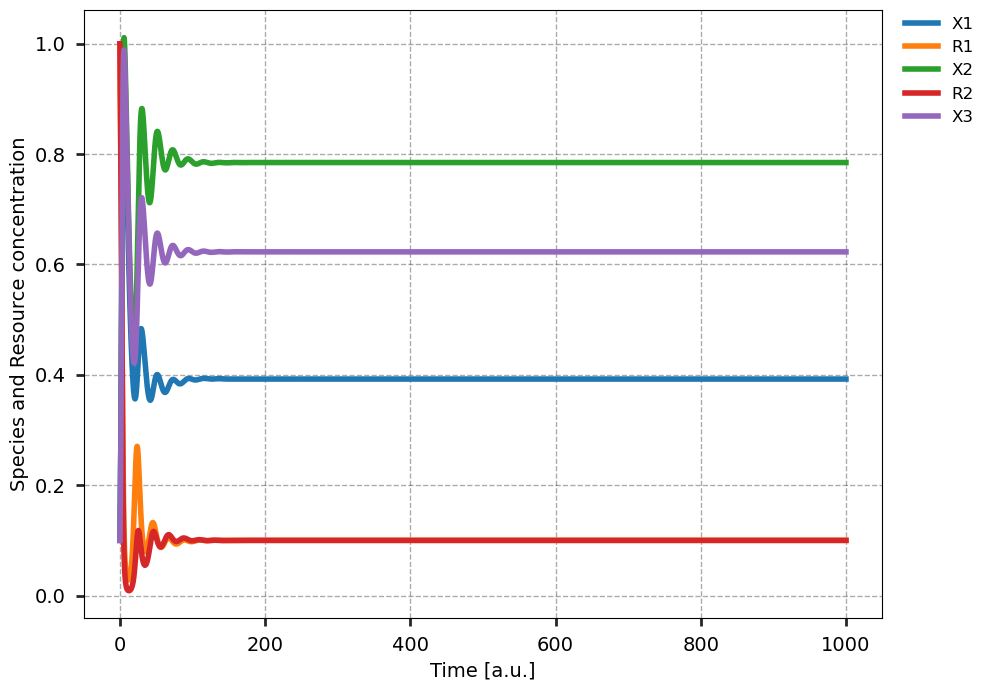

In [115]:
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from modelbase.ode import Model, Simulator
from typing import Iterable, Collection


def species1(X1, R1, R2, C1, a1_1, a1_2, w1, w2, T1):
    return X1 * C1 * ((a1_1 * w1 * R1 + a1_2 * w2 * R2) - T1)


def species2(X2, R1, R2, C2, a2_1, a2_2, w1, w2, T2):
    return X2 * C2 * ((a2_1 * w1 * R1 + a2_2 * w2 * R2) - T2)


def species3(X3, R1, R2, C3, a3_1, a3_2, w1, w2, T3):
    return X3 * C3 * ((a3_1 * w1 * R1 + a3_2 * w2 * R2) - T3)


def resource1(R1, X1, X2, X3, r1, K1, a1_1, a2_1, a3_1):
    return R1 * (
        r1 / K1 * (K1 - R1) - (a1_1 * X1 + a2_1 * X2 + a3_1 * X3)
    )  # ALL SPECIES MUST BE INCLUDED


def resource2(R2, X1, X2, X3, r2, K2, a1_2, a2_2, a3_2):
    return R2 * (
        r2 / K2 * (K2 - R2) - (a1_2 * X1 + a2_2 * X2 + a3_2 * X3)
    )  # ALL SPECIES MUST BE INCLUDED


def get_model() -> Model:
    p = {
        "C1": 1,
        "a1_1": 0.3,
        "a1_2": 0.7,
        "w1": 1,
        "T1": 0.1,  # ai_k = aj_k i=Species k=Resource
        "C2": 1,
        "a2_1": 0.6,
        "a2_2": 0.4,
        "w2": 1,
        "T2": 0.1,  # w=weight
        "C3": 1,
        "a3_1": 0.5,
        "a3_2": 0.5,
        "T3": 0.1,
        "r1": 1,
        "K1": 1,
        "r2": 1,
        "K2": 1,
    }

    m = Model(p)
    m.add_compounds(["X1", "R1", "X2", "R2", "X3"])
    m.add_reaction_from_args(
        rate_name="dXdt1",
        function=species1,
        stoichiometry={"X1": 1},
        args=["X1", "R1", "R2", "C1", "a1_1", "a1_2", "w1", "w2", "T1"],
    )

    m.add_reaction_from_args(
        rate_name="dXdt2",
        function=species2,
        stoichiometry={"X2": 1},
        args=["X2", "R1", "R2", "C2", "a2_1", "a2_2", "w1", "w2", "T2"],
    )

    m.add_reaction_from_args(
        rate_name="dXdt3",
        function=species3,
        stoichiometry={"X3": 1},
        args=["X3", "R1", "R2", "C3", "a3_1", "a3_2", "w1", "w2", "T3"],
    )

    m.add_reaction_from_args(
        rate_name="dRdt1",
        function=resource1,
        stoichiometry={"R1": 1},
        args=["R1", "X1", "X2", "X3", "r1", "K1", "a1_1", "a2_1", "a3_1"],
    )

    m.add_reaction_from_args(
        rate_name="dRdt2",
        function=resource2,
        stoichiometry={"R2": 1},
        args=["R2", "X1", "X2", "X3", "r2", "K2", "a1_2", "a2_2", "a3_2"],
    )
    return m


y0 = {"X1": 0.1, "X2": 0.1, "X3": 0.1, "R1": 1, "R2": 1}

s = Simulator(get_model())
s.initialise(y0)
s.simulate(1000)
s.plot()


plt.xlabel("Time [a.u.]")
plt.ylabel("Species and Resource concentration")
print(s.simulate_to_steady_state()[1])

In [119]:
from __future__ import annotations

import itertools
from functools import partial
from typing import Callable
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


def _scan(
    ij: tuple[float, float], m: Callable[[], Model], threshold: float
) -> tuple[float, float, dict[str, float | None]]:
    i, j = ij
    s = Simulator(m())
    s.update_parameters({"a1_1": i, "a1_2": j})
    s.initialise(y0)
    _, y_ss = s.simulate_to_steady_state()
    if y_ss is not None:
        return i, j, s.get_results_df().loc[:, ["X1", "X2", "X3"]].iloc[-1].to_dict()  # type: ignore
    return i, j, {"X1": None, "X2": None, "X3": None}


def perform_scan(
    m: Callable[[], Model], a11: Collection[float], a12: Collection[float]
) -> pd.DataFrame:
    results = list(
        tqdm(
            map(partial(_scan, m=m, threshold=1e-3), itertools.product(a11, a12)),
            total=len(a11) * len(a12),
        )
    )
    results = {(i, j): res for i, j, res in results}
    return pd.DataFrame(res).T


a11_min, a11_max = 0.2, 0.8
a12_min, a12_max = 0.2, 0.8

res = perform_scan(
    get_model,
    np.linspace(a11_min, a11_max, 5),
    np.linspace(a12_min, a12_max, 5),
)

threshold = 0.01
survived = (res > threshold).sum(axis=1)  # False is 0, True is 1

  0%|          | 0/25 [00:00<?, ?it/s]

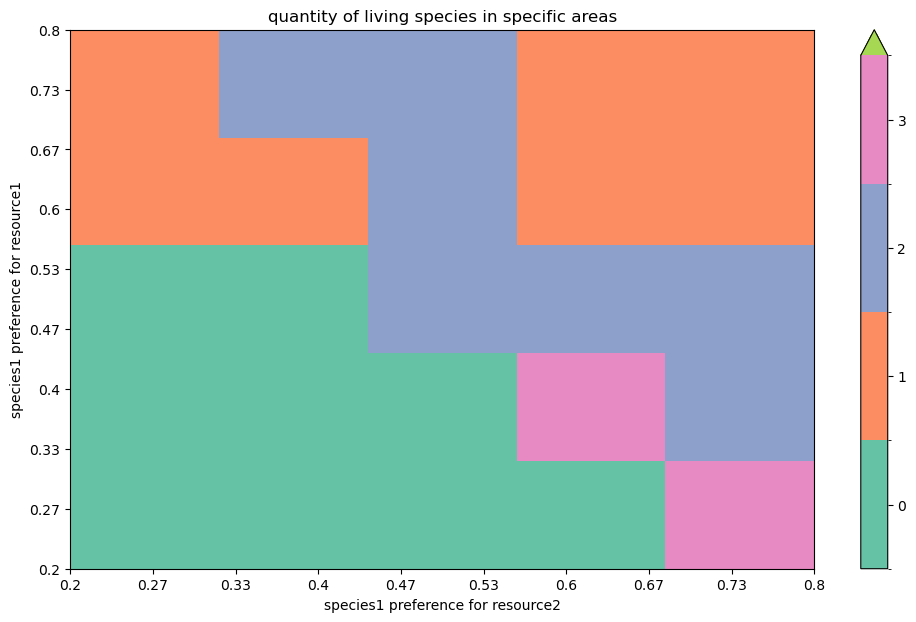

In [121]:
df = survived.unstack()
cmap, norm = matplotlib.colors.from_levels_and_colors(
    levels=range(5),
    colors=sns.color_palette("Set2", 5),
    extend="max",
)

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.pcolormesh(df, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=np.arange(4) + 0.5)
cbar.ax.set_yticklabels(range(4))

ax.set_xlabel("species1 preference for resource2")
ax.set_ylabel("species1 preference for resource1")
ax.set_title("quantity of living species in specific areas")

n = 10  # Say you explicitly want 10 ticks
ax.set_xticks(np.linspace(0, len(df.index), n))
ax.set_xticklabels(np.linspace(a11_min, a11_max, n).round(2))
ax.set_yticks(np.linspace(0, len(df.columns), n))
ax.set_yticklabels(np.linspace(a12_min, a12_max, n).round(2))
plt.show()

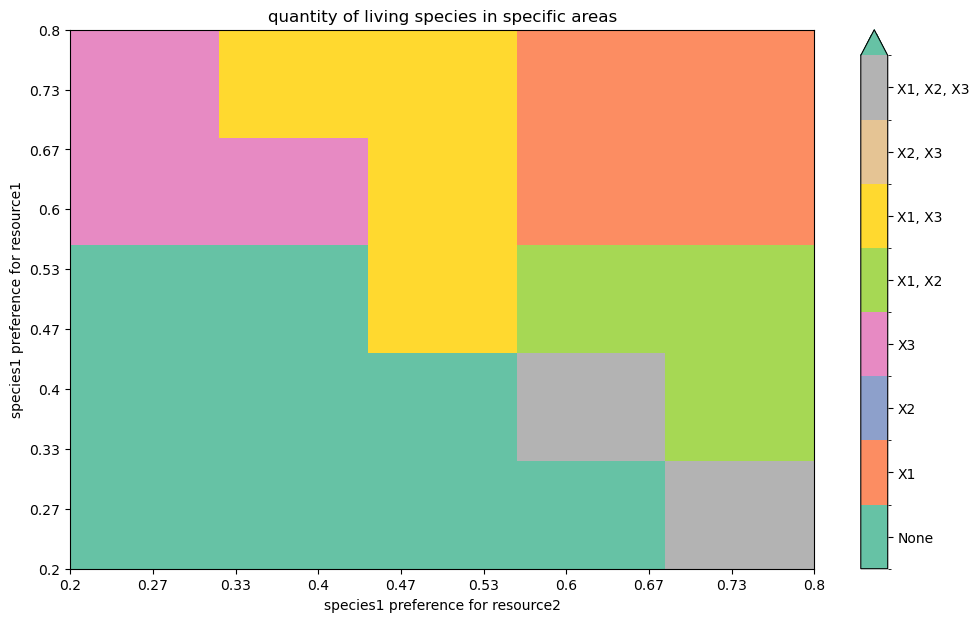

In [122]:
colors = {
    "None": 0,
    "X1": 1,
    "X2": 2,
    "X3": 3,
    "X1, X2": 4,
    "X1, X3": 5,
    "X2, X3": 6,
    "X1, X2, X3": 7,
}

data = {}
for ij, s in (res > threshold).iterrows():
    d = []
    for k, v in s.to_dict().items():
        if v == True:
            d.append(k)
    value = ", ".join(d)
    data[ij] = colors.get(value, 0)

df2 = pd.Series(data).unstack()

cmap, norm = matplotlib.colors.from_levels_and_colors(
    levels=[0, 1, 2, 3, 4, 5, 6, 7, 8],
    colors=sns.color_palette("Set2", 9),
    extend="max",
)

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.pcolormesh(df2, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=np.arange(len(colors)) + 0.5)
cbar.ax.set_yticklabels(colors.keys())

ax.set_xlabel("species1 preference for resource2")
ax.set_ylabel("species1 preference for resource1")
ax.set_title("quantity of living species in specific areas")

n = 10  # Say you explicitly want 10 ticks
ax.set_xticks(np.linspace(0, len(df2.index), n))
ax.set_xticklabels(np.linspace(a11_min, a11_max, n).round(2))
ax.set_yticks(np.linspace(0, len(df2.columns), n))
ax.set_yticklabels(np.linspace(a12_min, a12_max, n).round(2))
plt.show()

In [123]:
from __future__ import annotations

import itertools
from functools import partial
from typing import Callable
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor


def _scan(
    ij: tuple[float, float], m: Callable[[], Model], threshold: float
) -> tuple[float, float, float | None]:
    i, j = ij
    s = Simulator(m())
    s.update_parameters({"a1_1": i, "a1_2": j})
    s.initialise(y0)
    _, y_ss = s.simulate_to_steady_state()
    if y_ss is not None:
        survived = sum(np.take(y_ss[-1], [0, 2, 4]) > threshold)
        return i, j, survived
    s.initialise(y0)
    _, y_ss = s.simulate(10000)
    if y_ss is not None:
        # TODO: check if this actually *is* a steady state!
        # E.g. compare y_ss[-2] and y_ss[-1], they should be very close
        survived = sum(np.take(y_ss[-1], [0, 2, 4]) > threshold)
        return i, j, survived
    return i, j, None


def get_survived(
    m: Callable[[], Model], a11: Collection[float], a12: Collection[float]
) -> pd.DataFrame:
    results = list(
        tqdm(
            map(partial(_scan, m=m, threshold=1), itertools.product(a11, a12)),
            total=len(a11) * len(a12),
        )
    )
    d = pd.DataFrame(results)
    d.columns = ["a", "b", "c"]
    return d.pivot(index="a", columns="b", values="c")


# d_long = d.pivot(index='a',columns='b',values='c')


a11_min, a11_max = 0.2, 0.8
a12_min, a12_max = 0.2, 0.8

df = get_survived(
    get_model,
    np.linspace(a11_min, a11_max, 145),
    np.linspace(a12_min, a12_max, 145),
)


def get_survived2(
    m: Callable[[], Model], a11: Collection[float], a12: Collection[float]
) -> pd.DataFrame:
    results = list(
        tqdm(
            map(partial(_scan, m=m, threshold=1e-3), itertools.product(a11, a12)),
            total=len(a11) * len(a12),
        )
    )
    d = pd.DataFrame(results)
    d.columns = ["a", "b", "c"]
    return d.pivot(index="a", columns="b", values="c")


# d_long = d.pivot(index='a',columns='b',values='c')


a11_min, a11_max = 0.2, 0.8
a12_min, a12_max = 0.2, 0.8

df2 = get_survived2(
    get_model,
    np.linspace(a11_min, a11_max, 145),
    np.linspace(a12_min, a12_max, 145),
)


def get_survived3(
    m: Callable[[], Model], a11: Collection[float], a12: Collection[float]
) -> pd.DataFrame:
    results = list(
        tqdm(
            map(partial(_scan, m=m, threshold=1e-10), itertools.product(a11, a12)),
            total=len(a11) * len(a12),
        )
    )
    d = pd.DataFrame(results)
    d.columns = ["a", "b", "c"]
    return d.pivot(index="a", columns="b", values="c")


# d_long = d.pivot(index='a',columns='b',values='c')


a11_min, a11_max = 0.2, 0.8
a12_min, a12_max = 0.2, 0.8

df3 = get_survived3(
    get_model,
    np.linspace(a11_min, a11_max, 145),
    np.linspace(a12_min, a12_max, 145),
)

  0%|          | 0/21025 [00:00<?, ?it/s]

In [ ]:
cmap, norm = matplotlib.colors.from_levels_and_colors(
    levels=[0, 1, 2, 3, 4],
    colors=sns.color_palette("magma", 4),
    extend="neither",
)

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.pcolormesh(df, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(["0", "1", "2", "3"])

ax.set_xlabel("species1 preference for resource2")
ax.set_ylabel("species1 preference for resource1")
ax.set_title("quantity of living species in specific areas - threshold 1")

n = 10  # Say you explicitly want 10 ticks
ax.set_xticks(np.linspace(0, len(df.index), n))
ax.set_xticklabels(np.linspace(a11_min, a11_max, n).round(2))
ax.set_yticks(np.linspace(0, len(df.columns), n))
ax.set_yticklabels(np.linspace(a12_min, a12_max, n).round(2))
plt.show()

cmap, norm = matplotlib.colors.from_levels_and_colors(
    levels=[0, 1, 2, 3, 4],
    colors=sns.color_palette("magma", 4),
    extend="neither",
)

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.pcolormesh(df2, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(["0", "1", "2", "3"])

ax.set_xlabel("species1 preference for resource2")
ax.set_ylabel("species1 preference for resource1")
ax.set_title("quantity of living species in specific areas - threshold 1e-3")

n = 10  # Say you explicitly want 10 ticks
ax.set_xticks(np.linspace(0, len(df2.index), n))
ax.set_xticklabels(np.linspace(a11_min, a11_max, n).round(2))
ax.set_yticks(np.linspace(0, len(df2.columns), n))
ax.set_yticklabels(np.linspace(a12_min, a12_max, n).round(2))
plt.show()

cmap, norm = matplotlib.colors.from_levels_and_colors(
    levels=[0, 1, 2, 3, 4],
    colors=sns.color_palette("magma", 4),
    extend="neither",
)

fig, ax = plt.subplots(figsize=(12, 7))
im = ax.pcolormesh(df3, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.ax.set_yticklabels(["0", "1", "2", "3"])

ax.set_xlabel("species1 preference for resource2")
ax.set_ylabel("species1 preference for resource1")
ax.set_title("quantity of living species in specific areas - threshold: 1e-10")

n = 10  # Say you explicitly want 10 ticks
ax.set_xticks(np.linspace(0, len(df3.index), n))
ax.set_xticklabels(np.linspace(a11_min, a11_max, n).round(2))
ax.set_yticks(np.linspace(0, len(df3.columns), n))
ax.set_yticklabels(np.linspace(a12_min, a12_max, n).round(2))
plt.show()

In [ ]:
df3